# 텍스트 요약

:::info

이 튜토리얼에서는 기본 체인과 [LangGraph](https://langchain-ai.github.io/langgraph/)를 사용하여 텍스트 요약 방법을 보여줍니다.

이 페이지의 [이전 버전](https://python.langchain.com/v0.1/docs/use_cases/summarization/)에서는 기존 체인인 [StuffDocumentsChain](/docs/versions/migrating_chains/stuff_docs_chain/), [MapReduceDocumentsChain](/docs/versions/migrating_chains/map_reduce_chain/), [RefineDocumentsChain](https://python.langchain.com/docs/versions/migrating_chains/refine_docs_chain/)을 소개했습니다. 이러한 추상화 사용 방법과 이 튜토리얼에서 설명하는 방법과의 비교는 [여기](/docs/versions/migrating_chains/)에서 확인할 수 있습니다.

:::

PDF, Notion 페이지, 고객 질문 등 여러 문서가 있고 그 내용을 요약하고 싶다고 가정해 봅시다. 

LLM은 텍스트를 이해하고 요약하는 능력이 뛰어나 이러한 작업에 적합합니다.

[검색 증강 생성(RAG)](/docs/tutorials/rag) 맥락에서 텍스트를 요약하면 많은 수의 검색된 문서 정보를 압축해 LLM이 참고할 수 있는 문맥을 제공할 수 있습니다.

이번 안내서에서는 여러 문서의 내용을 LLM으로 요약하는 방법을 살펴보겠습니다.


![Image description](../../static/img/summarization_use_case_1.png)

## 개념

이번 튜토리얼에서 다룰 개념은 다음과 같습니다:

- [언어 모델](/docs/concepts/chat_models) 사용하기.

- [문서 로더](/docs/concepts/document_loaders) 사용하기. 특히 HTML 웹페이지에서 콘텐츠를 로드할 때 [WebBaseLoader](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html)를 활용합니다.

- 문서를 요약하거나 결합하는 두 가지 방법
  1. 문서를 단순히 하나의 프롬프트로 이어 붙이는 [Stuff](/docs/tutorials/summarization#stuff)
  2. 많은 문서를 처리하기 위한 [Map-reduce](/docs/tutorials/summarization#map-reduce) 방식. 문서를 여러 배치로 나눈 뒤 각 배치를 요약하고, 그 요약들을 다시 요약합니다.

이러한 전략과 [반복 정제](/docs/how_to/summarize_refine) 등을 다루는 짧고 집중적인 가이드는 [How-to 가이드](/docs/how_to/#summarization)에서 확인할 수 있습니다.


## 개요

요약기를 만들 때 핵심 질문은 문서를 LLM의 컨텍스트 창에 어떻게 전달할 것인가입니다. 이를 위한 일반적인 두 가지 방법은 다음과 같습니다.

1. `Stuff`: 모든 문서를 하나의 프롬프트에 그대로 "채워 넣는" 방식입니다. 가장 단순한 접근법이며, 이 방법에 사용되는 `create_stuff_documents_chain` 생성자에 대해서는 [여기](/docs/how_to/summarize_stuff/)를 참고하세요.

2. `Map-reduce`: "맵" 단계에서 각 문서를 따로 요약한 뒤, 그 요약들을 "리듀스" 단계에서 최종 요약으로 합치는 방식입니다. 이 방법에 사용되는 `MapReduceDocumentsChain`에 대한 자세한 내용은 [여기](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.map_reduce.MapReduceDocumentsChain.html)를 참고하세요.

맵-리듀스는 개별 문서의 이해가 이전 맥락에 의존하지 않을 때 특히 효과적입니다. 예를 들어 짧은 문서가 많은 코퍼스를 요약할 때 유용합니다. 반대로 소설처럼 순서가 중요한 긴 텍스트를 요약할 때는 [반복 정제](/docs/how_to/summarize_refine)가 더 적합할 수 있습니다.


![Image description](../../static/img/summarization_use_case_2.png)

## 설정

먼저 환경 변수를 설정하고 필요한 패키지를 설치합니다:


In [ ]:
%pip install --upgrade --quiet tiktoken langchain langgraph beautifulsoup4 langchain-community

# Set env var OPENAI_API_KEY or load from a .env file
# import dotenv

# dotenv.load_dotenv()

In [2]:
import os

os.environ["LANGSMITH_TRACING"] = "true"

먼저 문서를 불러옵니다. 블로그 글을 로드하기 위해 [WebBaseLoader](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html)를 사용하겠습니다:


In [4]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

다음으로 사용할 LLM을 선택합니다:

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs
  customVarName="llm"
/>


In [5]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Stuff: 한 번의 LLM 호출로 요약하기 {#stuff}

다음과 같이 큰 컨텍스트 윈도우를 가진 모델을 사용할 때는 [create_stuff_documents_chain](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.stuff.create_stuff_documents_chain.html)을 사용할 수 있습니다:

* 128k 토큰 OpenAI `gpt-4o`
* 200k 토큰 Anthropic `claude-3-5-sonnet-20240620`

이 체인은 문서 목록을 받아 모두 하나의 프롬프트에 삽입한 뒤 그 프롬프트를 LLM에 전달합니다:


In [6]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

# Instantiate chain
chain = create_stuff_documents_chain(llm, prompt)

# Invoke chain
result = chain.invoke({"context": docs})
print(result)

The article "LLM Powered Autonomous Agents" by Lilian Weng discusses the development and capabilities of autonomous agents powered by large language models (LLMs). It outlines a system architecture that includes three main components: Planning, Memory, and Tool Use. 

1. **Planning** involves task decomposition, where complex tasks are broken down into manageable subgoals, and self-reflection, allowing agents to learn from past actions to improve future performance. Techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT) are highlighted for enhancing reasoning and planning.

2. **Memory** is categorized into short-term and long-term memory, with mechanisms for fast retrieval using Maximum Inner Product Search (MIPS) algorithms. This allows agents to retain and recall information effectively.

3. **Tool Use** enables agents to interact with external APIs and tools, enhancing their capabilities beyond the limitations of their training data. Examples include MRKL systems and fra

### 스트리밍

결과를 토큰 단위로 스트리밍할 수도 있습니다:


In [7]:
for token in chain.stream({"context": docs}):
    print(token, end="|")

|The| article| "|LL|M| Powered| Autonomous| Agents|"| by| Lil|ian| W|eng| discusses| the| development| and| capabilities| of| autonomous| agents| powered| by| large| language| models| (|LL|Ms|).| It| outlines| a| system| architecture| that| includes| three| main| components|:| Planning|,| Memory|,| and| Tool| Use|.| 

|1|.| **|Planning|**| involves| task| decomposition|,| where| complex| tasks| are| broken| down| into| manageable| sub|go|als|,| and| self|-ref|lection|,| allowing| agents| to| learn| from| past| actions| to| improve| future| performance|.| Techniques| like| Chain| of| Thought| (|Co|T|)| and| Tree| of| Thoughts| (|To|T|)| are| highlighted| for| enhancing| reasoning| and| planning|.

|2|.| **|Memory|**| is| categorized| into| short|-term| and| long|-term| memory|,| with| mechanisms| for| fast| retrieval| using| Maximum| Inner| Product| Search| (|M|IPS|)| algorithms|.| This| allows| agents| to| retain| and| recall| information| effectively|.

|3|.| **|Tool| Use|**| emphasiz

### 더 깊이 들어가기

* 프롬프트를 쉽게 커스터마이즈할 수 있습니다.
* `llm` 매개변수를 통해 [Claude](/docs/integrations/chat/anthropic)와 같은 다른 LLM을 간단히 시험해 볼 수 있습니다.


## Map-Reduce: 병렬화를 통한 긴 텍스트 요약 {#map-reduce}

맵-리듀스 접근법을 살펴보겠습니다. 먼저 각 문서를 LLM을 이용해 개별 요약으로 "맵"한 다음, 그 요약들을 하나의 전역 요약으로 "리듀스"합니다.

맵 단계는 보통 입력 문서 전체에 걸쳐 병렬로 수행됩니다.

`langchain-core` 위에 구축된 [LangGraph](https://langchain-ai.github.io/langgraph/)는 [맵-리듀스](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) 워크플로를 지원하며, 이 문제에 적합합니다:

- LangGraph는 각 단계(예: 연속 요약)를 스트리밍할 수 있어 실행 제어가 더 용이합니다.
- LangGraph의 [체크포인팅](https://langchain-ai.github.io/langgraph/how-tos/persistence/)은 오류 복구, 사람-중심 워크플로 확장, 대화형 애플리케이션 통합을 지원합니다.
- 아래에서 보겠지만 LangGraph 구현은 수정과 확장이 간단합니다.

### Map
먼저 맵 단계에 사용할 프롬프트를 정의합니다. `stuff` 방식에서 사용한 요약 프롬프트를 그대로 사용할 수 있습니다:


In [8]:
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

프롬프트를 저장하고 불러오기 위해 Prompt Hub를 사용할 수도 있습니다.

이는 [LangSmith API 키](https://docs.smith.langchain.com/)와 함께 작동합니다.

예를 들어 맵 프롬프트는 [여기](https://smith.langchain.com/hub/rlm/map-prompt)에서 확인할 수 있습니다.

```python
from langchain import hub

map_prompt = hub.pull("rlm/map-prompt")
```


### Reduce

맵 단계 결과를 하나의 출력으로 줄이기 위한 프롬프트도 정의합니다.


In [9]:
# Also available via the hub: `hub.pull("rlm/reduce-prompt")`
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

### LangGraph로 오케스트레이션하기

아래에서는 문서 목록을 요약한 뒤 위의 프롬프트를 사용해 이를 결합하는 간단한 애플리케이션을 구현합니다.

맵-리듀스 흐름은 텍스트 길이가 LLM의 컨텍스트 창보다 길 때 특히 유용합니다. 긴 텍스트를 다룰 때는 리듀스 단계에서 요약할 컨텍스트가 모델의 컨텍스트 창 크기를 넘지 않도록 하는 메커니즘이 필요합니다. 여기서는 요약을 재귀적으로 "축약"하는 방법을 구현합니다: 입력을 토큰 제한에 따라 분할하고 각 분할에 대해 요약을 생성합니다. 이 과정을 전체 요약 길이가 원하는 한도 내에 들어올 때까지 반복하여 임의 길이의 텍스트를 요약할 수 있습니다.


In [10]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Created a chunk of size 1003, which is longer than the specified 1000


Generated 14 documents.


다음으로 그래프를 정의합니다. 여기서는 "축약" 단계를 설명하기 위해 최대 토큰 길이를 1,000토큰으로 낮게 설정했습니다.


In [11]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke(state["content"])
    response = await llm.ainvoke(prompt)
    return {"summaries": [response.content]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

LangGraph는 그래프 구조를 시각화할 수 있어 동작을 이해하는 데 도움이 됩니다:


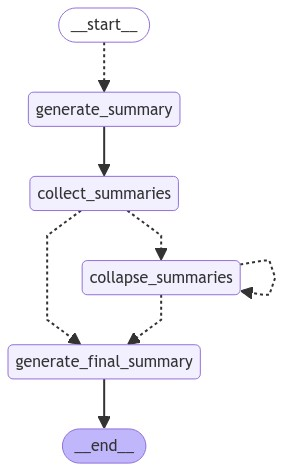

In [14]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

애플리케이션을 실행할 때 그래프를 스트리밍하여 실행 단계의 순서를 확인할 수 있습니다. 아래에서는 각 단계의 이름을 간단히 출력합니다.

그래프에 루프가 있기 때문에 실행 시 [recursion_limit](https://langchain-ai.github.io/langgraph/reference/errors/#langgraph.errors.GraphRecursionError)을 지정하면 도움이 됩니다. 한도를 초과하면 해당 오류가 발생합니다.


In [17]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['collapse_summaries']
['generate_final_summary']


In [31]:
print(step)

{'generate_final_summary': {'final_summary': 'The consolidated summary of the main themes from the provided documents is as follows:\n\n1. **Integration of Large Language Models (LLMs) in Autonomous Agents**: The documents explore the evolving role of LLMs in autonomous systems, emphasizing their enhanced reasoning and acting capabilities through methodologies that incorporate structured planning, memory systems, and tool use.\n\n2. **Core Components of Autonomous Agents**:\n   - **Planning**: Techniques like task decomposition (e.g., Chain of Thought) and external classical planners are utilized to facilitate long-term planning by breaking down complex tasks.\n   - **Memory**: The memory system is divided into short-term (in-context learning) and long-term memory, with parallels drawn between human memory and machine learning to improve agent performance.\n   - **Tool Use**: Agents utilize external APIs and algorithms to enhance problem-solving abilities, exemplified by frameworks lik

해당 [LangSmith 트레이스](https://smith.langchain.com/public/9d7b1d50-e1d6-44c9-9ab2-eabef621c883/r)에서는 각 노드별로 그룹화된 개별 LLM 호출을 확인할 수 있습니다.

### 더 깊이 들어가기

**커스터마이징**

* 위에서 본 것처럼 맵 단계와 리듀스 단계에서 사용할 LLM과 프롬프트를 자유롭게 구성할 수 있습니다.

**실제 사용 사례**

* [이 블로그 글](https://blog.langchain.dev/llms-to-improve-documentation/)은 사용자 상호작용(문서 질문)을 분석하는 사례 연구를 소개합니다.
* 이 블로그 글과 관련된 [저장소](https://github.com/mendableai/QA_clustering)는 요약 수단으로 클러스터링을 소개합니다.
* 이는 `stuff`나 `map-reduce` 방식 외에 고려해 볼 수 있는 또 다른 경로를 제시합니다.

![Image description](../../static/img/summarization_use_case_3.png)


## 다음 단계

다음 내용을 자세히 다루는 [How-to 가이드](/docs/how_to)를 참고해 보세요: 

- [반복 정제](/docs/how_to/summarize_refine)와 같은 다른 요약 전략
- 내장 [문서 로더](/docs/how_to/#document-loaders)와 [텍스트 분할기](/docs/how_to/#text-splitters)
- 다양한 문서 결합 체인을 [RAG 애플리케이션](/docs/tutorials/rag/)에 통합하기
- 검색을 [챗봇](/docs/how_to/chatbots_retrieval/)에 통합하기

그 밖의 여러 개념도 함께 확인할 수 있습니다.
